
# Tutorial 3: Chance constrained optimization
In this tutorial, we will:
- Setup and solve a chance constrained optimization problem using SOUPy and `scipy.optimize`.
- Show how to use cost functional objects as constraints.

To run this with MPI for parallel sampling, export this notebook as a python script.

## Problem definition

We use again use the Poisson equation with a log-normal coefficient field with a distributed source as the control. Since CVaR may be sample-intensive, 
to reduce the notebook's runtime, we will pose the problem in the 1D domain $\Omega = (0,1)$. Recall the PDE is given by,

\begin{align*}
\nabla \cdot (e^{m} \nabla u ) + z &= 0 \qquad x \in \Omega, \\
u &= 0 \qquad \text{at } x = 0, \\
u &= 1 \qquad \text{at } x = 1. \\
\end{align*}

Here $u$ is the PDE solution, $m$, the uncertain parameter, is the log-coefficient field, and $z$, the optimization variable, is a distributed source.
We will again use $R(u,m,z)$ to denote the strong residual of the PDE. The corresponding weak form, is 

$$
\text{Find } u \in \mathcal{U} \text{ s.t. } 
r(u,m,v,z):= 
\int_{\Omega} e^m \nabla u \cdot \nabla v dx - \int_{\Omega} z v dx = 0 \qquad \forall v \in \mathcal{V}
$$

with the trial and test spaces 

\begin{align*}
\mathcal{U} := \{u \in H^1(\Omega) : u = x \text{ on } \Gamma_{D} \}, \\
\mathcal{V} := \{v \in H^1(\Omega) : v = 0 \text{ on } \Gamma_{D} \}.
\end{align*}

As with tutorial 1, we choose the log-coefficient $m$ to be distributed as a Matern Gaussian random field, $m \sim \mathcal{N}(\bar{m}, \mathcal{C})$, where the covariance operator  $\mathcal{C} = \mathcal{A}^{-2}$ is given by the squared-inverse of an elliptic operator 

$$ \mathcal{A} = -\gamma \Delta + \delta \mathcal{I} $$

with Homogeneous Neumann boundary conditions. We will assume $(\gamma, \delta) = (0.5, 10)$ and $\bar{m} = -3$ is a constant.

The goal of our optimization problem is to reach a target source profile $z = 1$ while minimally disturbing the state from $u = x$. 
We can formulate this optimization problem as a chance-constrained optimization problem, 

$$ \min_{z} P(z) \qquad \text{s.t. PDE constraint and } \mathbb{P}[Q > \tau] < p_{\text{tol}} $$ 

using the objective function

$$ P(z) = \int_{\Omega}(z-1)^2 dx, $$ 

and the QoI

$$ Q = \int_{\Omega} (u - x)^2 dx. $$ 

Here, $\tau$ is some threshold value, $p_{\text{tol}}$ is the maximum allows probability of $Q$ exceeding the threshold.


Recall that the probability can be formulated in terms of an expectation over an indicator function 

$$ \mathbb{P}[Q > \tau] = \mathbb{E}[\mathbb{1}_{(0, \infty)}(Q - \tau)], $$

which, similar to the maximum function from the CVaR tutorial, is unfortunately not differentiable. We can also make a smooth approximation here, e.g. 

$$ \mathbb{1}_{\epsilon}(t) = \frac{1}{1 + \exp(-2x/\epsilon)}. $$

where $\epsilon > 0$ controls the approximation error. We can then formulate the chance-constrained optimization using the SAA for the probability of exceedance, 

$$ \min_{z} P(z) \qquad \text{s.t. PDE constraint and } \frac{1}{N}\sum_{i=1}^{N} \mathbb{1}_{\epsilon}(Q_i - \tau) < p_{\mathrm{tol}} $$ 

## 1. Import libraries 
Note: hippylib and soupy paths need to be appended if cloning the repos instead of installing via pip

In [1]:
import sys 
import os 
sys.path.append(os.environ.get('HIPPYLIB_PATH')) # Needed if using cloned repo
sys.path.append(os.environ.get('SOUPY_PATH')) # Needed if using cloned repo
import time

import logging 
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)

import scipy.optimize 
import numpy as np 
import matplotlib.pyplot as plt 
import dolfin as dl 
import hippylib as hp 
from mpi4py import MPI 

import soupy 

## 2. Setup the function space
We will set up the mesh in 1D. Note that we will implement the code to be amenable for parallel sampling (see tutorial 1a). 
To do so, we give the mesh the `MPI.COMM_SELF` communicator and save the `MPI.COMM_WORLD` communicator for sampling.

In [2]:
N_ELEMENTS_X = 16

comm_mesh = MPI.COMM_SELF
comm_sampler = MPI.COMM_WORLD

mesh = dl.UnitIntervalMesh(comm_mesh, N_ELEMENTS_X) # Using MPI.COMM_SELF for the mesh so it does not partition

Vh_STATE = dl.FunctionSpace(mesh, "CG", 1)
Vh_PARAMETER = dl.FunctionSpace(mesh, "CG", 1)
Vh_CONTROL = dl.FunctionSpace(mesh, "CG", 1)
Vh = [Vh_STATE, Vh_PARAMETER, Vh_STATE, Vh_CONTROL] 

## 3. Define the PDE problem and Prior
This is the same as in tutorial 1, except for the change in the definition of the boundaries. 

In [3]:
# Define PDE 

def residual(u,m,v,z):
    return dl.exp(m)*dl.inner(dl.grad(u), dl.grad(v))*dl.dx - z * v *dl.dx 

def boundary(x, on_boundary):
    return on_boundary and (dl.near(x[0], 0) or dl.near(x[0], 1))

boundary_value = dl.Expression("x[0]", degree=1, mpi_comm=comm_mesh) # Need to use the same mpi_comm as the mesh

bc = dl.DirichletBC(Vh_STATE, boundary_value, boundary)
bc0 = dl.DirichletBC(Vh_STATE, dl.Constant(0.0), boundary)
pde = soupy.PDEVariationalControlProblem(Vh, residual, [bc], [bc0], is_fwd_linear=True)

# Define prior
PRIOR_GAMMA = 1.0
PRIOR_DELTA = 10.0
PRIOR_MEAN = -3.0

mean_vector = dl.interpolate(dl.Constant(PRIOR_MEAN), Vh_PARAMETER).vector()
prior = hp.BiLaplacianPrior(Vh_PARAMETER, PRIOR_GAMMA, PRIOR_DELTA, mean=mean_vector, robin_bc=False)


## 4. Define the QoI and control model
Here we prescribe the new QoI in its variational form. Note that in this example, the QoI will be in the constraint. 

In [4]:
# Define QoI
target_expression = dl.Expression("x[0]", degree=1, mpi_comm=comm_mesh)

def l2_qoi_form(u,m,z):
    return (u - target_expression)**2*dl.dx 

qoi = soupy.VariationalControlQoI(Vh, l2_qoi_form)

# Combine into control model
control_model = soupy.ControlModel(pde, qoi)

## 5. Define the probability of exceedance as a risk measure.
We will define the probability of exceedance using the `soupy.TransformedMeanRiskMeasureSAASettings` class, which supports a risk of the form

$$ g\left( \mathbb{E}[f(Q)] \right),$$

where $f$ and $g$ are functions of scalar variables. 

In the case of the chance constraint, we have $g(x) = x$ and $f(x) = \mathbb{1}_{\epsilon}(x - \tau)$. These two functions can be supplied to the risk measure class in the parameter list, `soupy.transformedMeanRiskMeasureSAASettings`, as `inner_function` for $f$ and `outer_function` for $g$. 

These are to be provided using the `soupy.FunctionWrapper` class, which will use finite differences to compute the derivatives of the function if not supplied. 

Note that by default, the `inner_function` and `outer_function` will be set to identity functions $f(x) = x$ and $g(x) = x$.

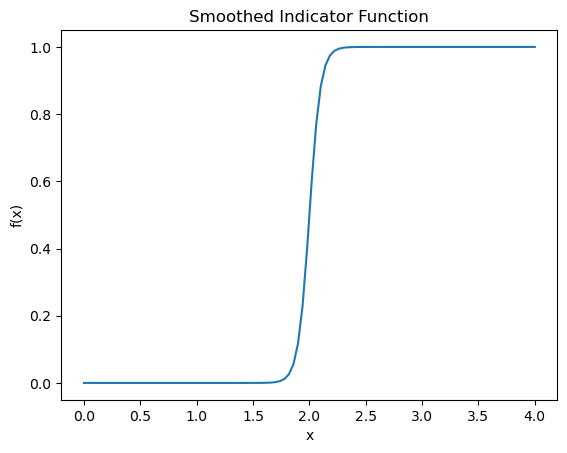

In [5]:
TAU = 2.0 # QoI threshold value 
EPSILON = 1e-1
smoothed_indicator_form = lambda x : 1/ (1 + np.exp(-2 * (x - TAU)/EPSILON)) # Smoothed indicator function
smoothed_indicator = soupy.FunctionWrapper(smoothed_indicator_form) 

x_plot = np.linspace(0, 2*TAU, 100)

if comm_sampler.rank == 0:
    plt.figure()
    plt.plot(x_plot, smoothed_indicator_form(x_plot))
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title("Smoothed Indicator Function")

SAMPLE_SIZE = 400
RANDOM_SEED = 1

risk_settings = soupy.transformedMeanRiskMeasureSAASettings()
risk_settings["sample_size"] = SAMPLE_SIZE 
risk_settings["seed"] = RANDOM_SEED
risk_settings["inner_function"] = smoothed_indicator # Outer function will be identity by default 

risk_measure = soupy.TransformedMeanRiskMeasureSAA(control_model, prior, risk_settings, comm_sampler=comm_sampler)

chance_constraint = soupy.RiskMeasureControlCostFunctional(risk_measure, penalization=None)


## 6. Define the penalization and cost functional
We now proceed to define the optimization objective as a penalization term since it does not depend on the PDE solution. 

This is then converted to a cost functional using the class `soupy.PenalizationControlCostFunctional`.

In [6]:
Z_TARGET = 1.0 
def l2_objective_form(z):
    return (z- dl.Constant(Z_TARGET))**2*dl.dx 

penalty = soupy.VariationalPenalization(Vh, l2_objective_form)

l2_objective = soupy.PenalizationControlCostFunctional(Vh, penalty)

## 7. Optimization using SciPy
We will now use the SciPy wrapper to define the cost functional and chance constraints. We will use the SLSQP algorithm, which uses the first derivatives of the cost and the constraints.

We will need to set the upper bound on the constraint function to be $p_{\mathrm{tol}}$, which we take to be $0.05$ in this example. 

In [7]:
# Interface with scipy.optimize.minimize
scipy_cost = soupy.ScipyCostWrapper(l2_objective, verbose=False)
scipy_chance_constraint = soupy.ScipyCostWrapper(chance_constraint, verbose=False)

P_TOL = 0.05
constraint = scipy.optimize.NonlinearConstraint(scipy_chance_constraint.function(), lb=-np.inf, ub=P_TOL, jac=scipy_chance_constraint.jac())

z_initial_np = chance_constraint.generate_vector(soupy.CONTROL).get_local()
DISPLAY_ITERATIONS = True
MAX_ITER = 200
options = {'disp' : DISPLAY_ITERATIONS, 'maxiter' : MAX_ITER}

# Use the SLSQP algorithm for constrained optimization
results = scipy.optimize.minimize(scipy_cost.function(), z_initial_np, method="SLSQP", constraints=constraint,
    jac=scipy_cost.jac(), options=options)

z_optimal_np = results['x']


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.09339550500373343
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20


## 8. Postprocessing
We will now plot a sample of the parameter and solution at the optimal control.

Since the result is in the form of a numpy array for the augmented vector, we need to set it to a dolfin vector for solving the PDE. 
Remember to exclude the last component when setting it to a vector representing the control variable. 

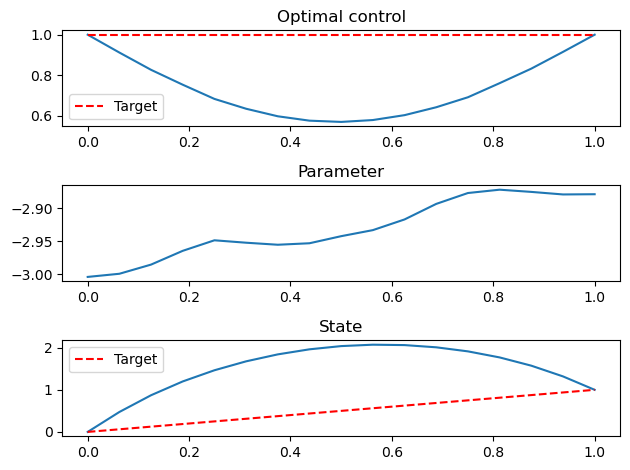

In [8]:

# Initialize vectors for the state, parameter, adjoint (not used) and control variables
x = control_model.generate_vector()

# Initialize the noise vector 
noise = dl.Vector(comm_mesh)
prior.init_vector(noise, "noise")

# Use hippylib's rng to sample Gaussian white noise 
rng = hp.Random(seed=111)

# This is sampling noise with 1.0 standard dev to the noise vector
rng.normal(1.0, noise) 

# The prior then turns the noise into a parameter sample
prior.sample(noise, x[soupy.PARAMETER])

# Also set the CONTROL component of x to the optimal control z
x[soupy.CONTROL].set_local(z_optimal_np)

# Solve the forward problem
control_model.solveFwd(x[soupy.STATE], x)

# Convert to functions and plot
u_fun = dl.Function(Vh[soupy.STATE], x[soupy.STATE])
m_fun = dl.Function(Vh[soupy.PARAMETER], x[soupy.PARAMETER])
z_fun = dl.Function(Vh[soupy.CONTROL], x[soupy.CONTROL])

x_obs = np.linspace(0, 1, 100)
if comm_sampler.rank == 0:
    plt.figure()
    plt.subplot(311)
    dl.plot(z_fun, title="Optimal control")
    plt.plot(x_obs, Z_TARGET*np.ones_like(x_obs), '--r', label="Target")
    plt.legend()

    plt.subplot(312)
    dl.plot(m_fun, title="Parameter")

    plt.subplot(313)
    dl.plot(u_fun, title="State")
    plt.plot(x_obs, x_obs, '--r', label="Target")
    plt.legend()

    plt.tight_layout()

### Distribution of QoIs at optimal controls
We can now sample the QoI distribution using the optimal control. We will compare this against directly using the target value of $z = 1$. 
As with the CVaR tutorial, we will make a new risk measure as the evaluation risk measure to do the sampling. 

In [9]:
SAMPLE_SIZE = 2000
RANDOM_SEED = 111

risk_settings_evaluation = soupy.meanVarRiskMeasureSAASettings()
risk_settings_evaluation["sample_size"] = SAMPLE_SIZE 
risk_settings_evaluation["seed"] = RANDOM_SEED
risk_evaluation = soupy.MeanVarRiskMeasureSAA(control_model, prior, risk_settings_evaluation, comm_sampler=comm_sampler)

# Constrained 
z = risk_evaluation.generate_vector(soupy.CONTROL)
z.set_local(z_optimal_np)
risk_evaluation.computeComponents(z, order=0)
qoi_samples_constrained = risk_evaluation.gather_samples()

# Unconstrained, use z = 1
z = dl.interpolate(dl.Constant(Z_TARGET), Vh[soupy.CONTROL]).vector()
risk_evaluation.computeComponents(z, order=0)
qoi_samples_unconstrained = risk_evaluation.gather_samples()



We plot the QoI distributions at the control from solving the chance-constrained optimization problem, $z^*$, and at the target control $z = 1$. 
Observe that when using the target control, the probability of exceedance is much larger than using the chance-constraint, which attempts to respect the $p_{p_\mathrm{tol}} = 0.05$ threshold. 

Note that the presence of errors in the smoothing approximation of the indicator and sample average approximation of the expectation means this constraint is not perfectly respected.


Probability of exceedance if using z = 1 (unconstrained): 0.996
Probability of exceedance if using chance constraint: 0.069


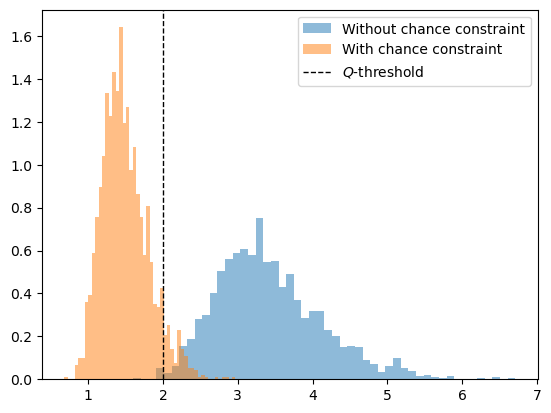

In [10]:
if comm_sampler.rank == 0:
    print("Probability of exceedance if using z = 1 (unconstrained): %g" %(np.mean(qoi_samples_unconstrained > TAU)))
    print("Probability of exceedance if using chance constraint: %g" %(np.mean(qoi_samples_constrained > TAU)))

    plt.figure()
    bar = plt.hist(qoi_samples_unconstrained, bins=50, density=True, alpha=0.5, label='Without chance constraint')
    bar = plt.hist(qoi_samples_constrained, bins=50, density=True, alpha=0.5, label='With chance constraint')
    plt.axvline(TAU, color='k', linestyle='dashed', linewidth=1, label="$Q$-threshold")
    plt.legend()
plt.show()
